# Import necessary packages

In [37]:
import pandas
import numpy
import retl
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import re
import helper
import scipy.stats
#import seaborn as sns
import matplotlib.gridspec as gridspec

# Data split GFP assay

In [38]:
dir_experiment='9REA8P'
experiment_name = 'Correlation'

data = []
time = []
n = 20

t0_data = retl.parse(fr'{dir_experiment}\read_01\Output.xml') 
t0 = t0_data['Label1_Copy1_Copy1'].end_utc

for i in range(0,n):
    rdata = retl.parse(fr'{dir_experiment}\read_{i+1:02d}\Output.xml')
    df = rdata['Label1_Copy1_Copy1'].value
    time_end = rdata['Label1_Copy1_Copy1'].end_utc
    runtime = (time_end-t0).seconds/3600
    data.append(df)
    time.append(runtime)
merged_outputs = pandas.concat(data, ignore_index = True)


mypath = fr'{dir_experiment}\{experiment_name}_Results' 
if not os.path.isdir(mypath):
    os.makedirs(mypath)

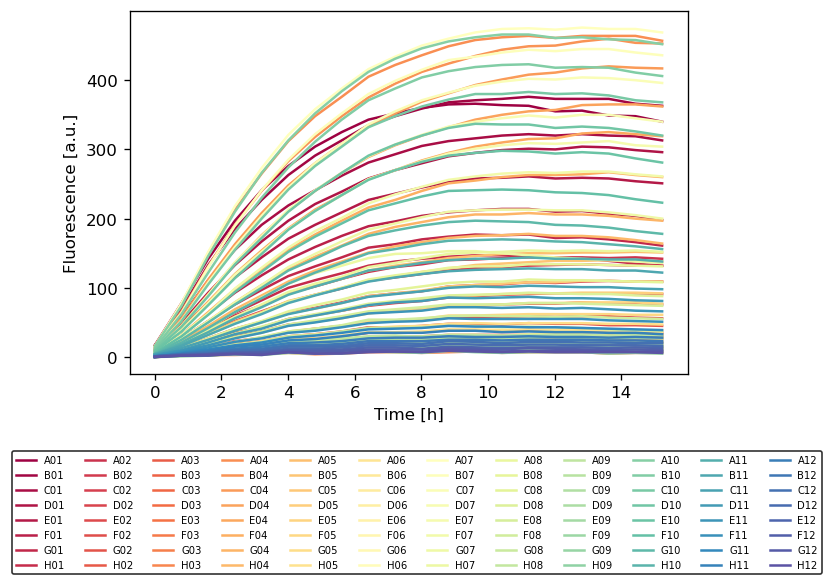

In [39]:
wells = []
for z in range(1, 13):
    z = f'{z:02}'
    well_rows = [f'{r}{z}' for r in 'ABCDEFGH']
    for w in well_rows:
        well = w
        wells.append(str(well))

fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120, sharex=True)

for w, well in enumerate(wells):
    color = plt.cm.Spectral(w/len(wells))
    ax.plot(time, merged_outputs[well], color = color, label = well)
    
#ax.set_xlim(0,18)
#ax.set_ylim(0,400)

ax.set_xlabel('Time [h]')
ax.set_ylabel('Fluorescence [a.u.]')

plt.legend(ncol = 12, edgecolor = 'black',  prop={'size':6}, bbox_to_anchor = (1.25,-0.2))
plt.savefig(fr'{dir_experiment}/{experiment_name}_Results/{experiment_name}_sGFP_all', dpi= 1200)

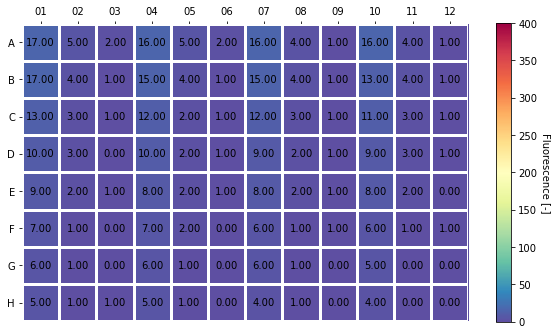

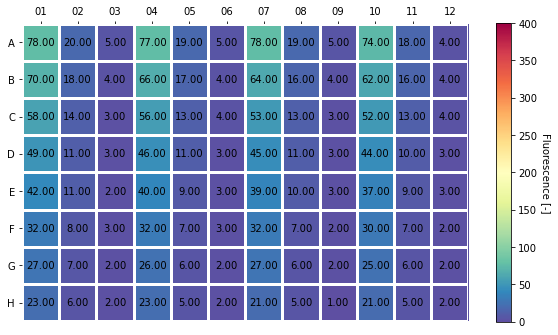

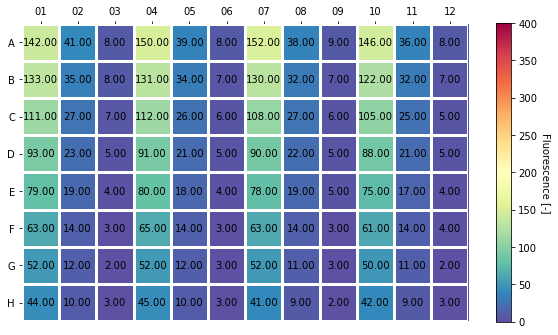

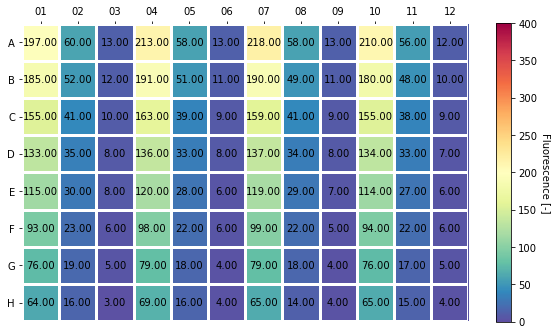

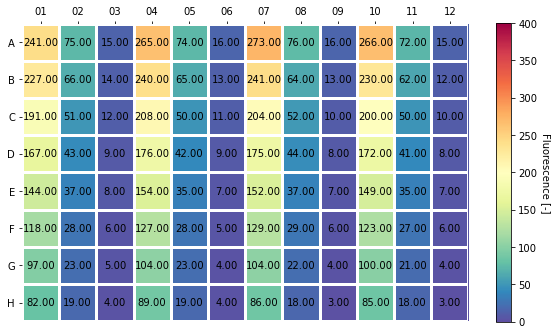

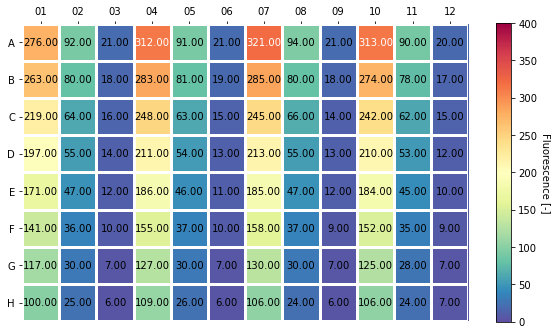

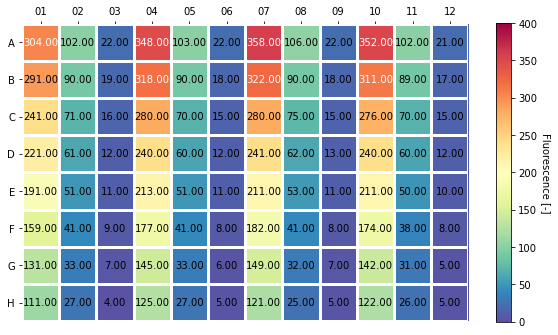

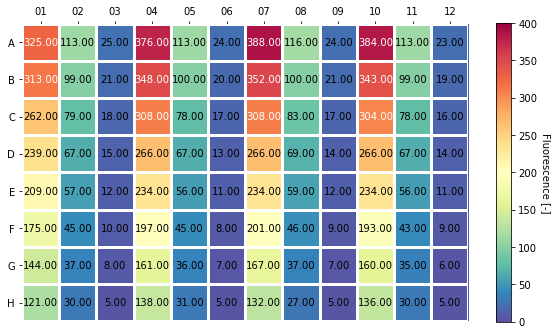

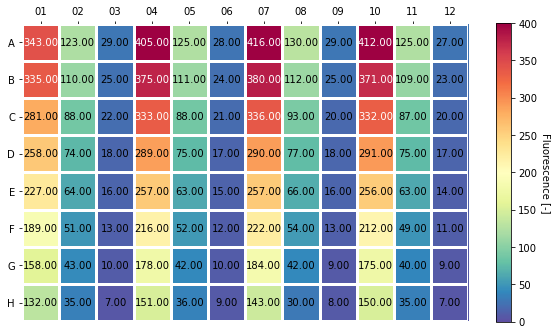

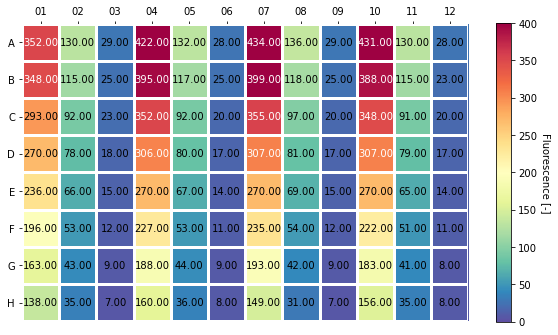

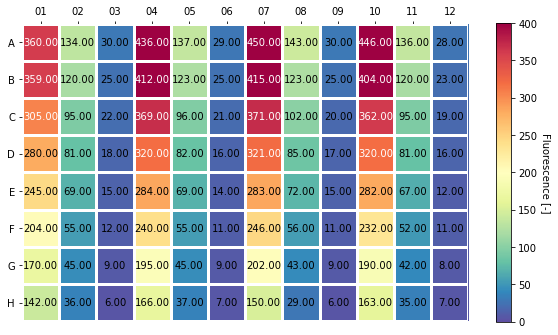

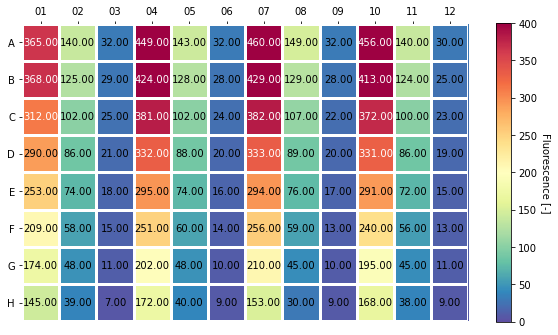

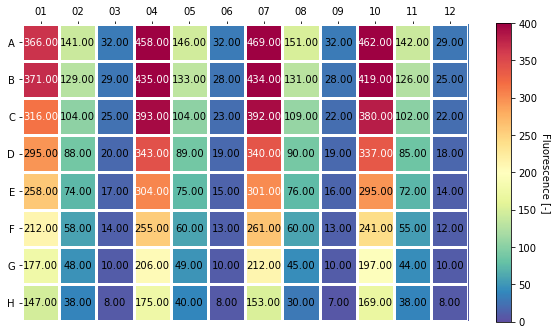

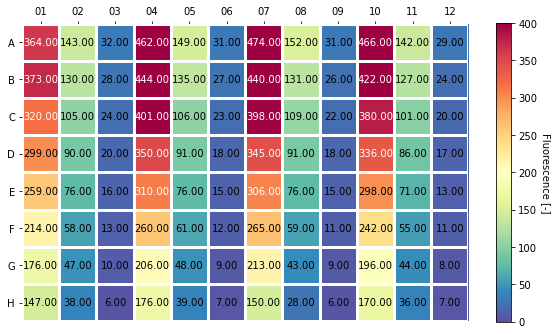

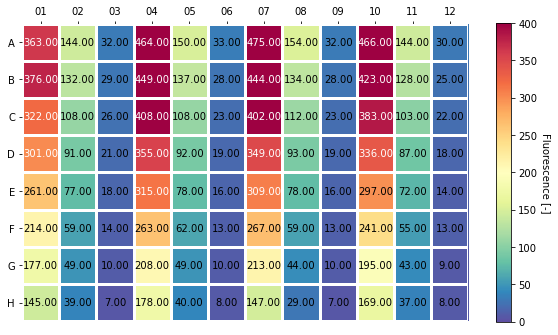

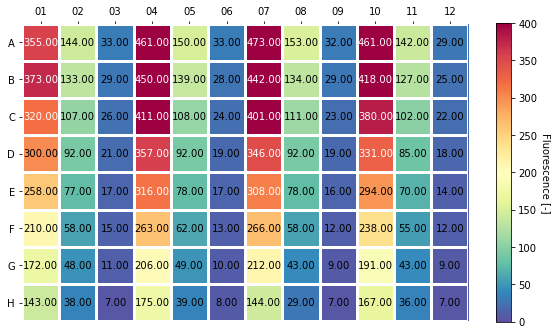

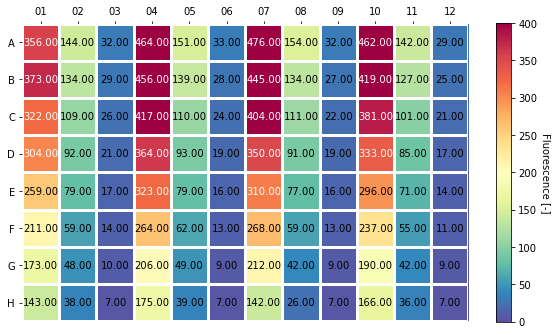

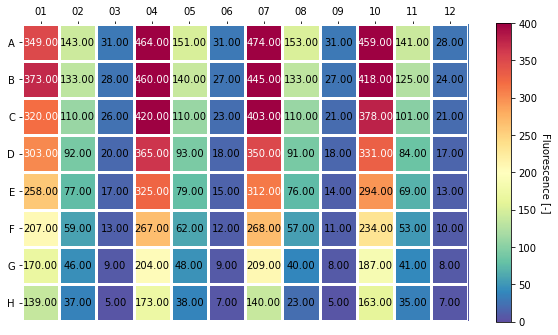

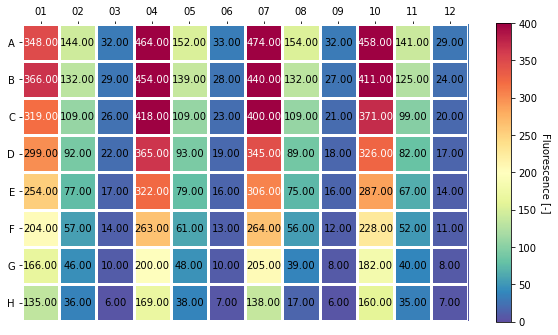

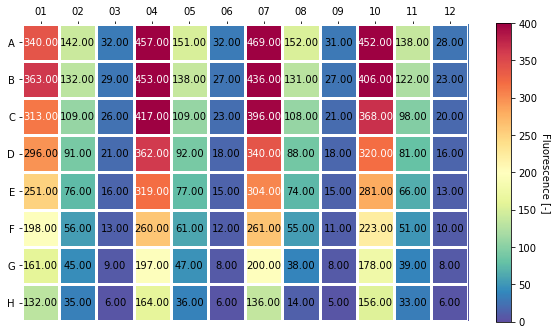

In [40]:
### Heatmap for all measurement points ###

row = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
column = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


for ai,x in enumerate(range(n)):
    fig, ax = plt.subplots(figsize = (10,10))
    array = numpy.array(merged_outputs.loc[x])
    array =array.reshape(8,12)
    
    im, cbar = helper.heatmap(array, row, column, ax = ax, cmap = 'Spectral_r',
                            cbar_kw = dict(shrink = 0.55), cbarlabel = 'Fluorescence [-]', vmin = 0, vmax = 400)
    texts = helper.annotate_heatmap(im, threshold = 300, valfmt = '{x:.2f}') #add annotations as two digit numbers



In [41]:
def getIndices(value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    position = pandas.read_excel(fr'{dir_experiment}/Wells.xlsx', sheet_name = 'MTP',index_col=0)
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = position.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((str(row)+str(col)))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos
#getIndices('YoaW')

C:\Users\muellerc\AppData\Local\Continuum\miniconda3\envs\dibecs_3.2.2\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


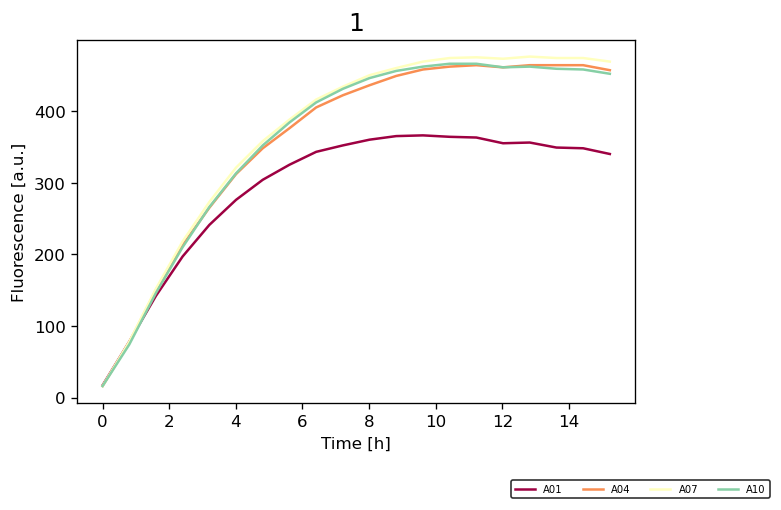

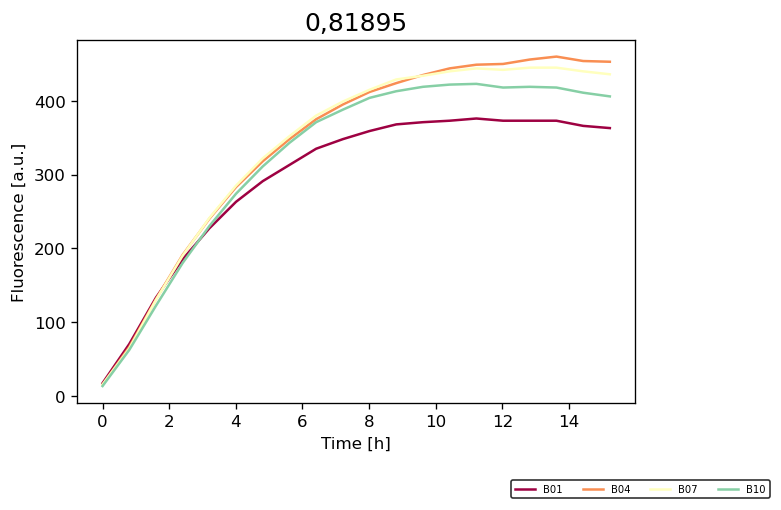

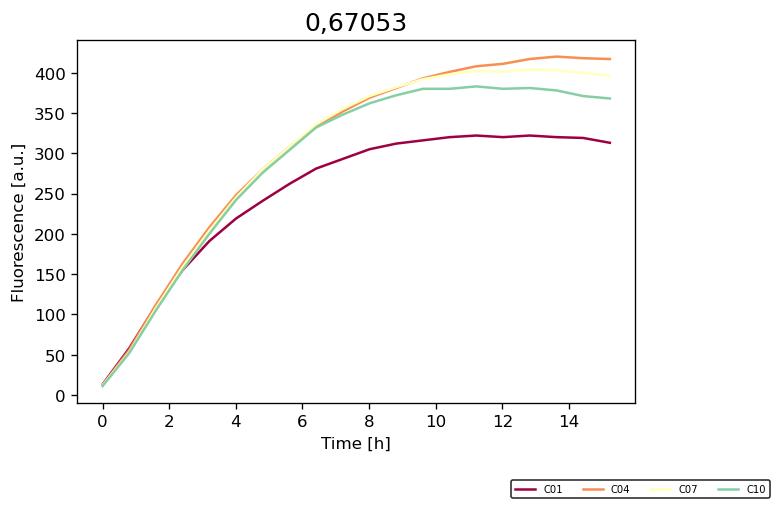

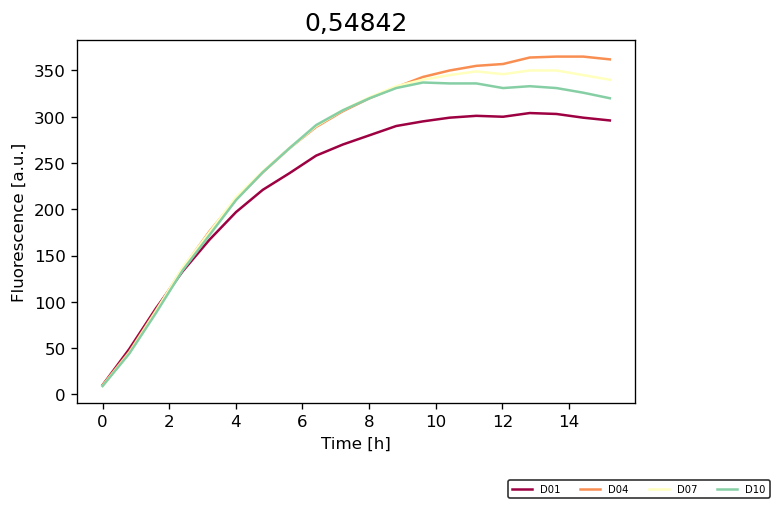

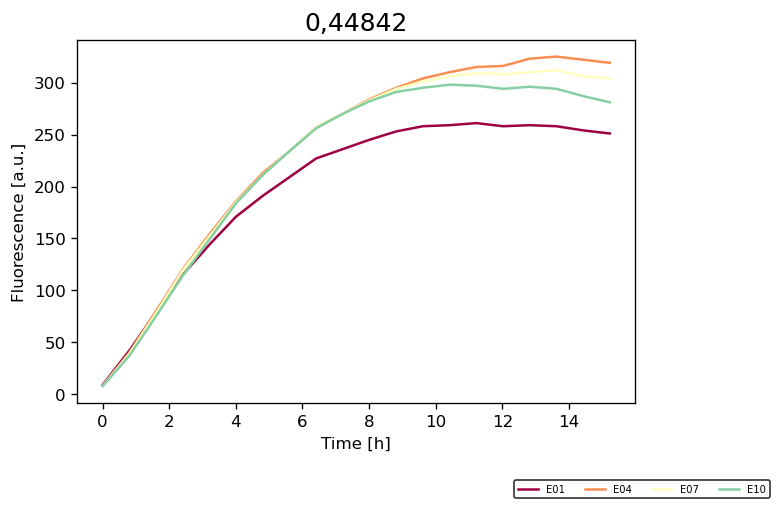

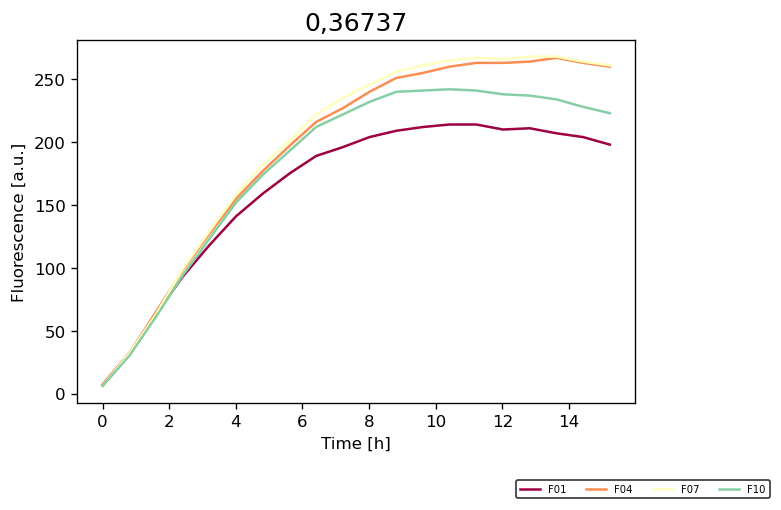

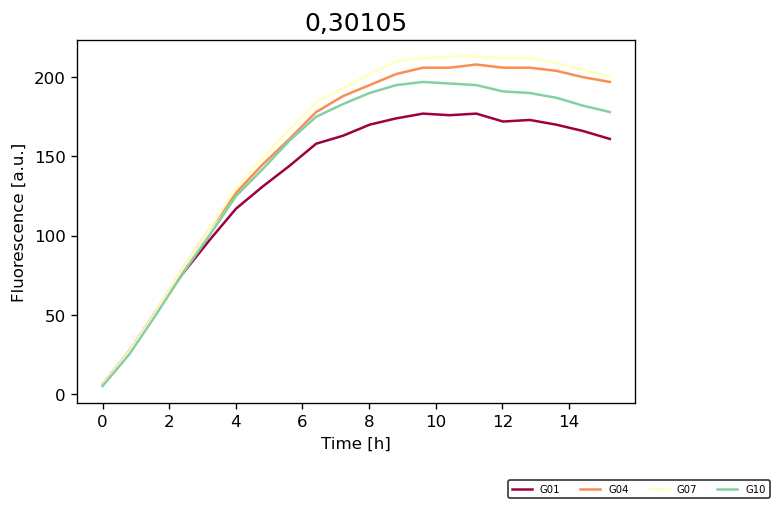

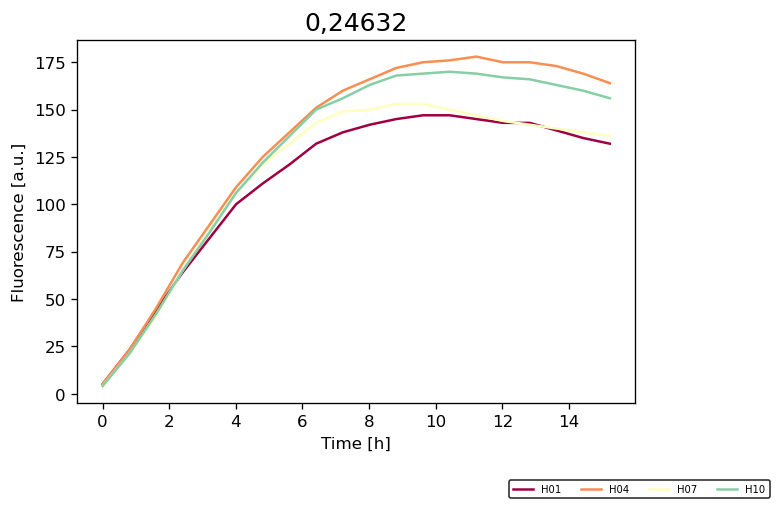

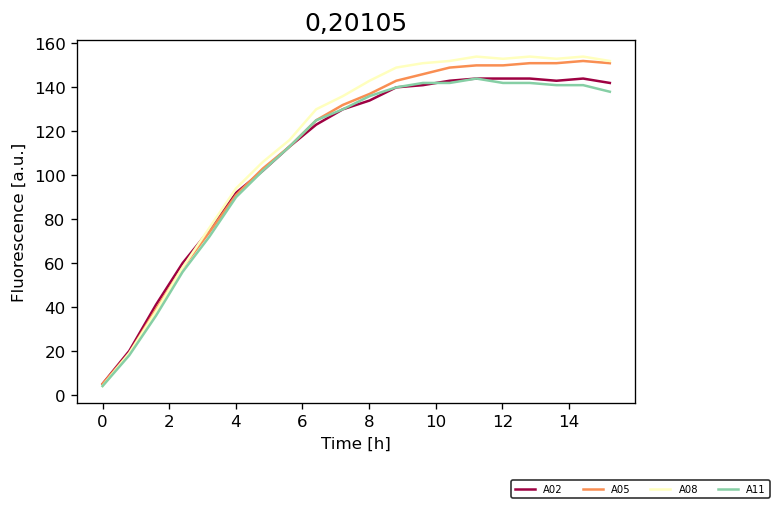

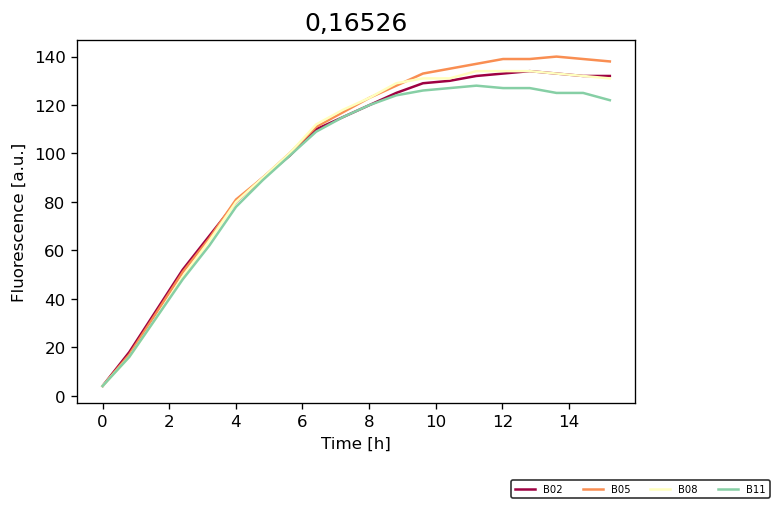

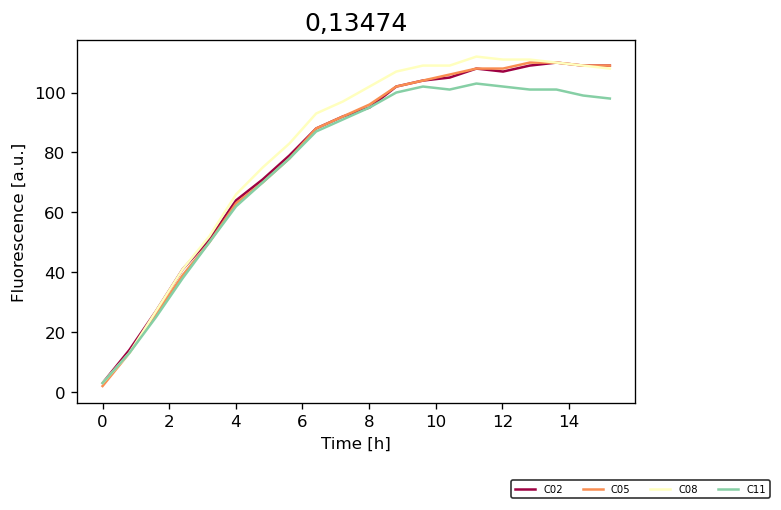

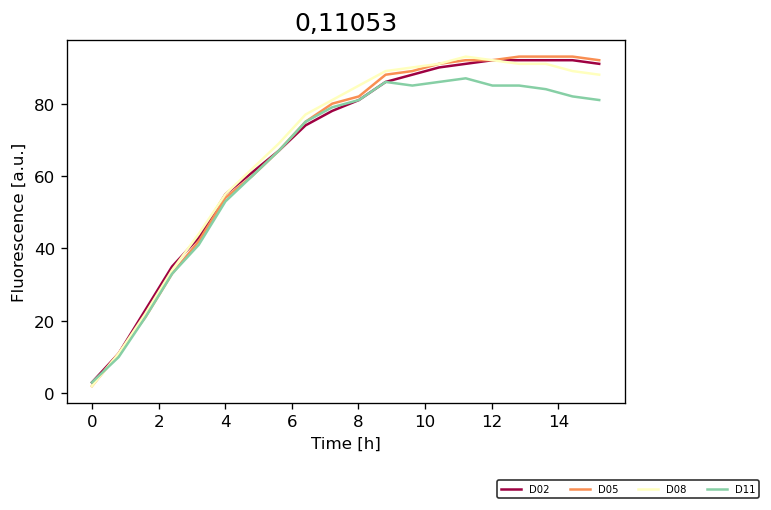

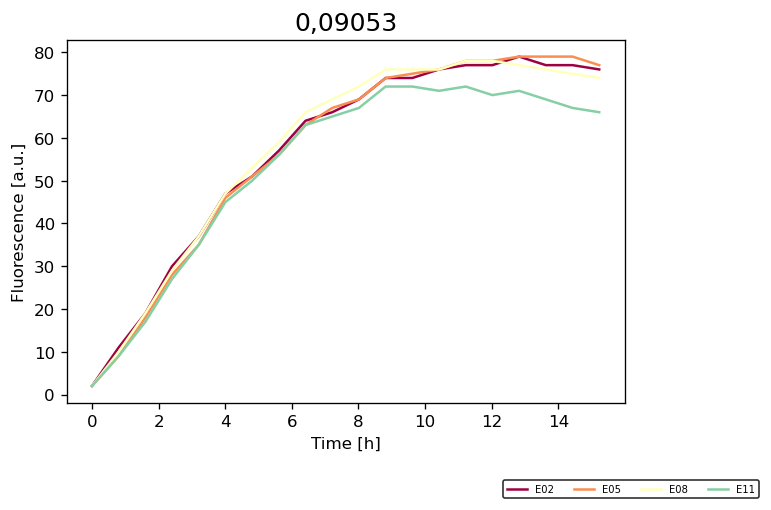

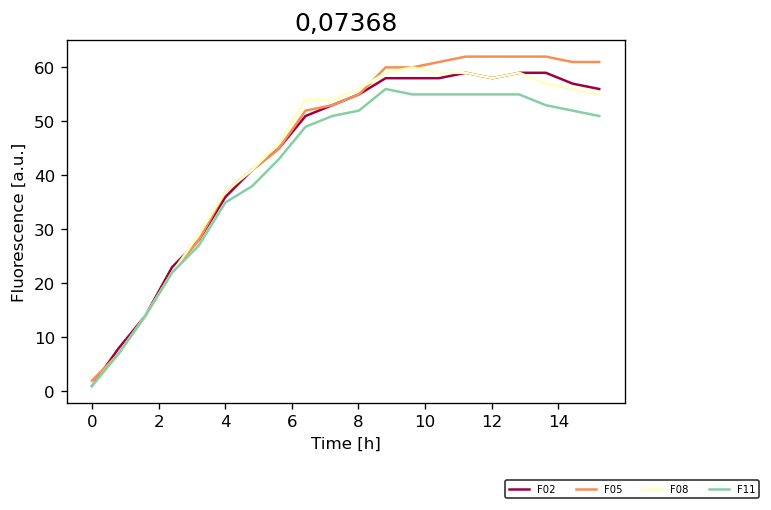

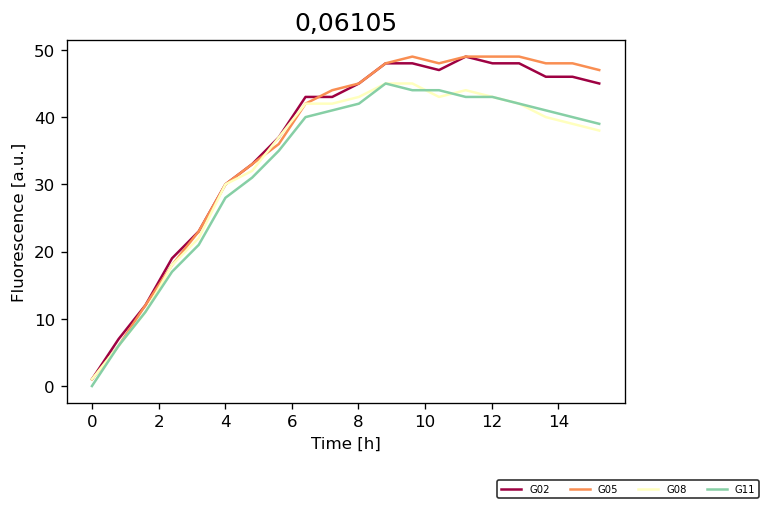

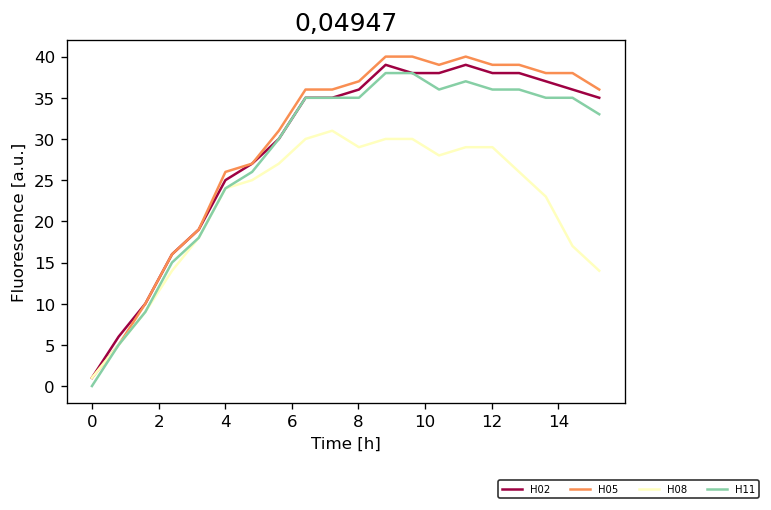

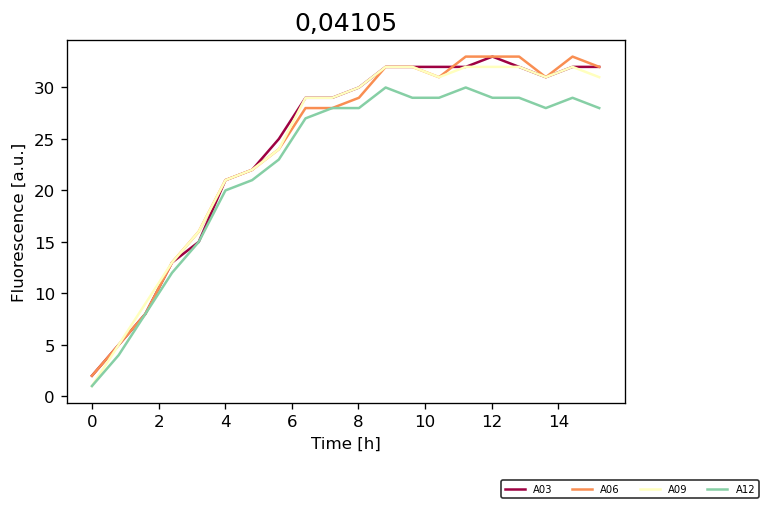

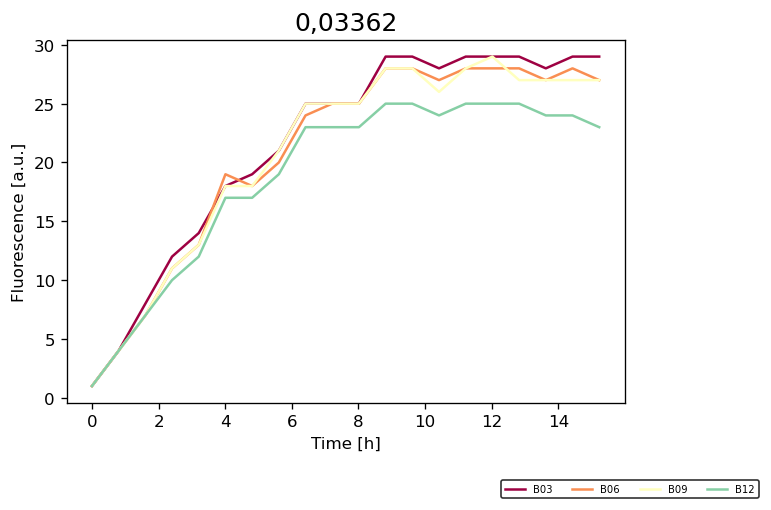

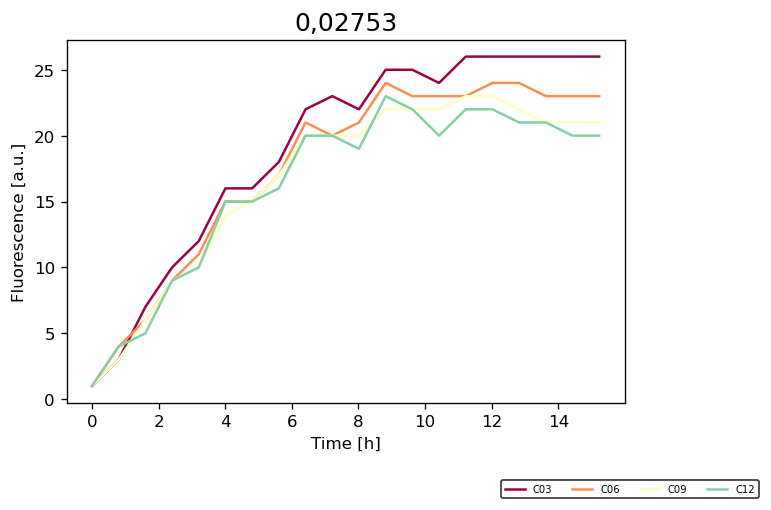

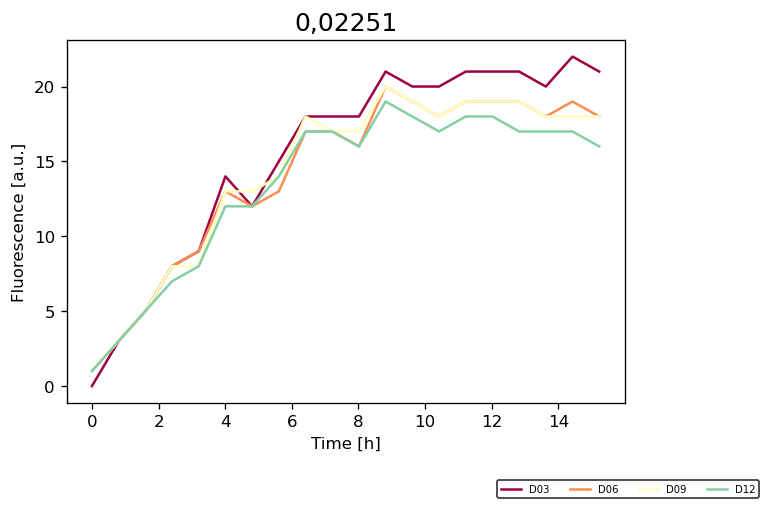

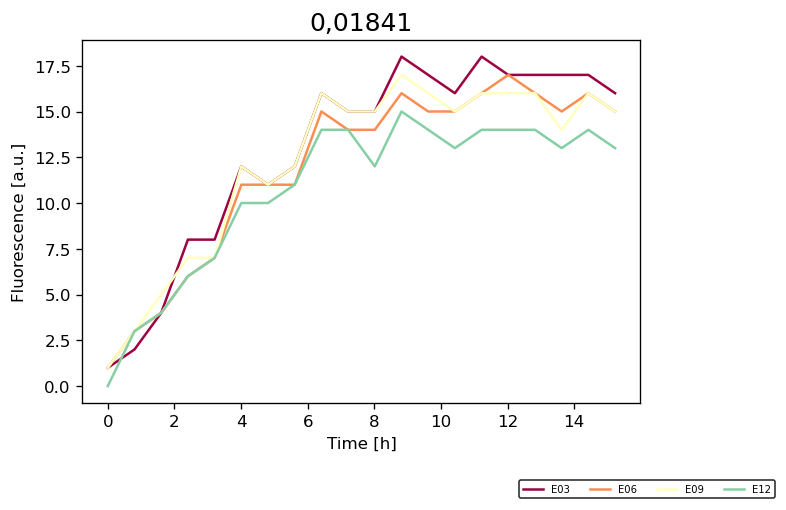

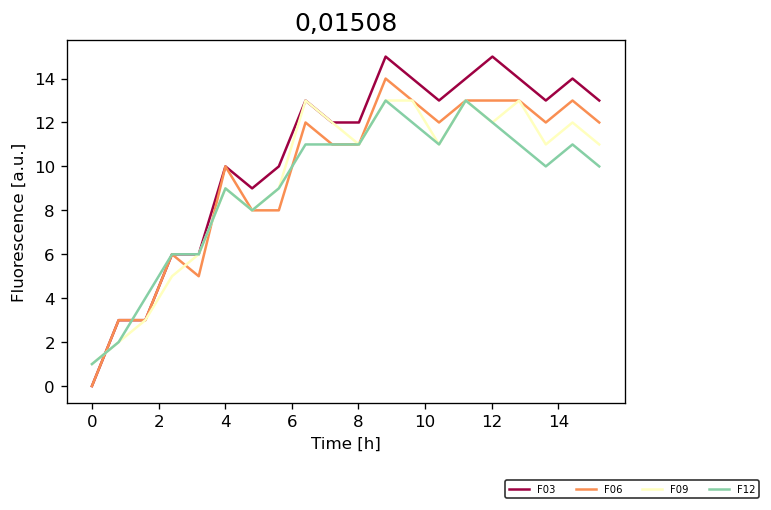

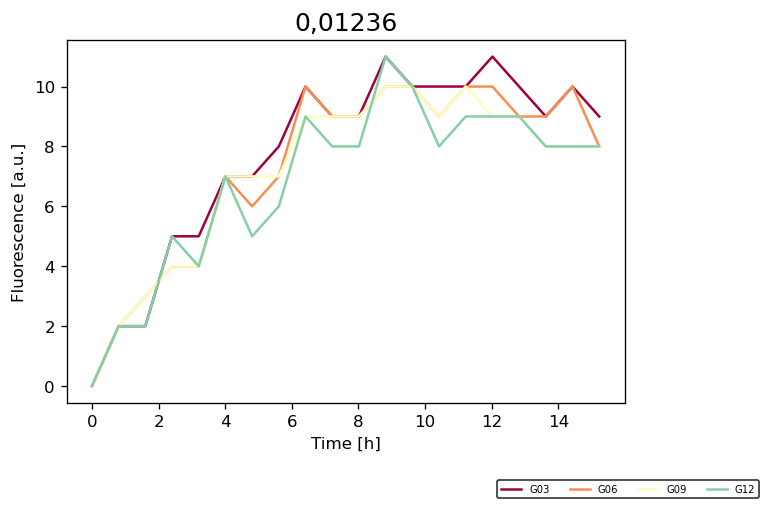

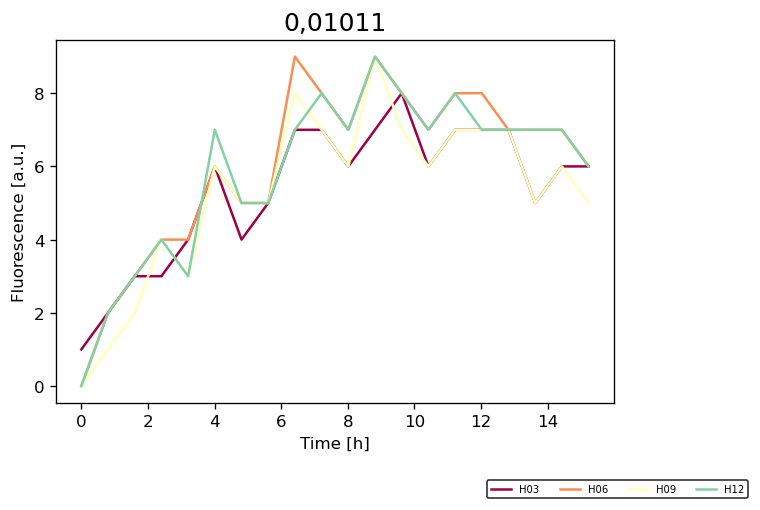

In [42]:
strain = ['1', '0,81895', '0,67053', '0,54842', '0,44842', '0,36737', '0,30105', '0,24632',
          '0,20105', '0,16526', '0,13474', '0,11053', '0,09053', '0,07368', '0,06105', '0,04947',
          '0,04105', '0,03362', '0,02753', '0,02251', '0,01841', '0,01508', '0,01236', '0,01011']
data = merged_outputs

for i,s in enumerate(strain):
    wells = getIndices(s)
    mean = data[wells].mean(axis=1)
    std = data[wells].std(axis=1)

    fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=120, sharex=True)

    for w, well in enumerate(wells):
        color = plt.cm.Spectral(w/len(wells))

        ax.plot(time, merged_outputs[well], color = color, label = well)

        
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('Fluorescence [a.u.]')
    ax.set_title('{}'.format(s), fontsize = 15)

    plt.legend(ncol = 12, edgecolor = 'black',  prop={'size':6}, bbox_to_anchor = (1.25,-0.2))
    plt.savefig(fr'{dir_experiment}/{experiment_name}_Results/{experiment_name}_sGFPraw_{s}', dpi= 300, bbox_inches='tight')

Text(0.5, 0, 'Time [h]')

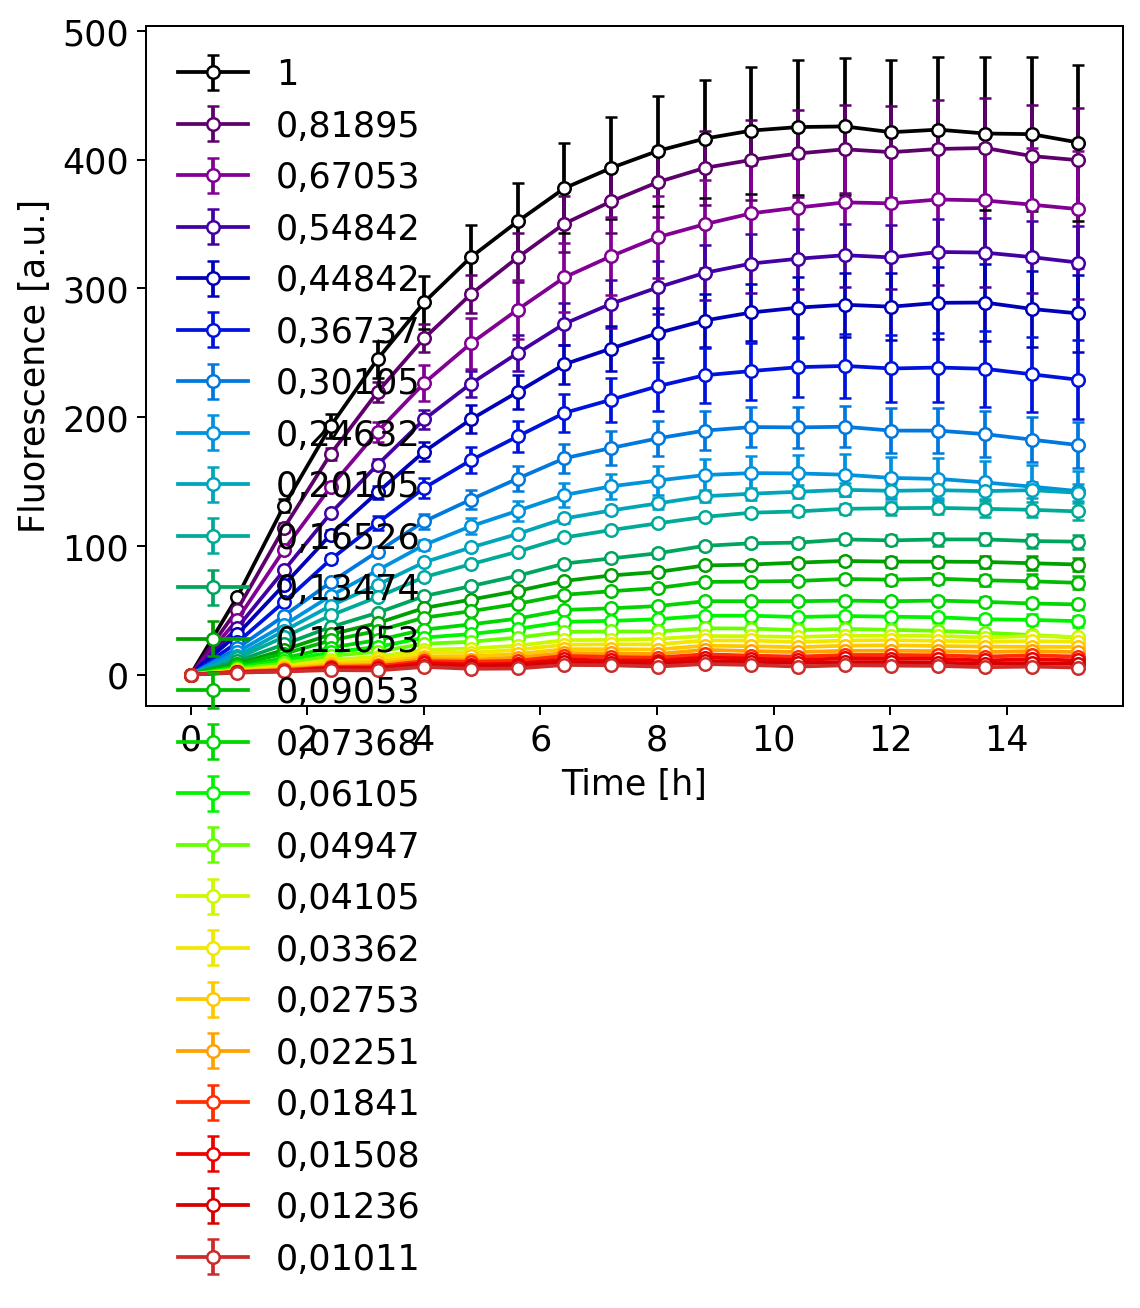

In [43]:
# strain = ['D1, S1', 'D2, S1', 'D3, S1', 'D4, S1']
#['D1, S1', 'D2, S1', 'D3, S1', 'D4, S1', 'D1, S2', 'D2, S2', 'D3, S2', 'D4, S2']
fontsize = 14

# labellist = ['Fresh detector solution', '7-month-old detector solution']
# colorlist = ['#023D6B', '#ADBDE3']
# markerlist = ['o', 's']

mean16h = []
std16h = []

#def plot_data(measurement,strain,induction):
meanplot = plt.figure(figsize=(7,5), dpi=180)

for i,s in enumerate(strain): 
    wells = getIndices(s)
    data[wells] = data[wells].apply(lambda x: x - numpy.min(x))
    
#     if s == '1':
#         wells.remove('A01')
    
    mean = data[wells].mean(axis=1)
    std = data[wells].std(axis=1)

    mean16h.append(mean[16]) # after approximately 12 h
    std16h.append(std[16]) # after approximately 12 h
    
    color = plt.cm.nipy_spectral(i / len(strain))

    plt.errorbar(time, mean, yerr = std, fmt = 'o-', capsize = 2.5,  ms = 5, marker = 'o', mfc = 'white',  color = color, label = s)

plt.legend(loc = 'upper left', frameon = False, fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.ylabel('Fluorescence [a.u.]', fontsize = fontsize)
plt.xlabel('Time [h]', fontsize = fontsize)

In [44]:
meanplot.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_sGFP', dpi=600, bbox_inches='tight')

# Data cutinase assay vs. sGFP

In [45]:
# safe fluorescence after 16 h and deviation in excel sheet

sGFP_16h = pandas.DataFrame({'Dilution' : strain,
                             'Fluorescence [a.u.]' : mean16h,
                             'Standard deviation' : std16h }, 
                             columns=['Dilution','Fluorescence [a.u.]', 'Standard deviation'])


sGFP_16h.to_excel(excel_writer = fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_sGFP.xlsx', sheet_name = 'sGFP')

sGFP_16h

,Dilution,Fluorescence [a.u.],Standard deviation
0,1,423.25,56.505899
1,"0,81895",408.25,37.774551
2,"0,67053",369.00,42.528422
3,"0,54842",328.25,25.927784
4,"0,44842",288.75,28.087660
5,"0,36737",238.50,26.714540
6,"0,30105",189.50,17.406895
7,"0,24632",152.00,16.492423
8,"0,20105",143.25,5.737305
9,"0,16526",129.50,4.932883


In [46]:
ca = pandas.read_excel(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_cutinase.xlsx', sheet_name = 'cutinase',index_col=0)
sGFP = pandas.read_excel(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_result_sGFP.xlsx', sheet_name = 'sGFP',index_col=0)

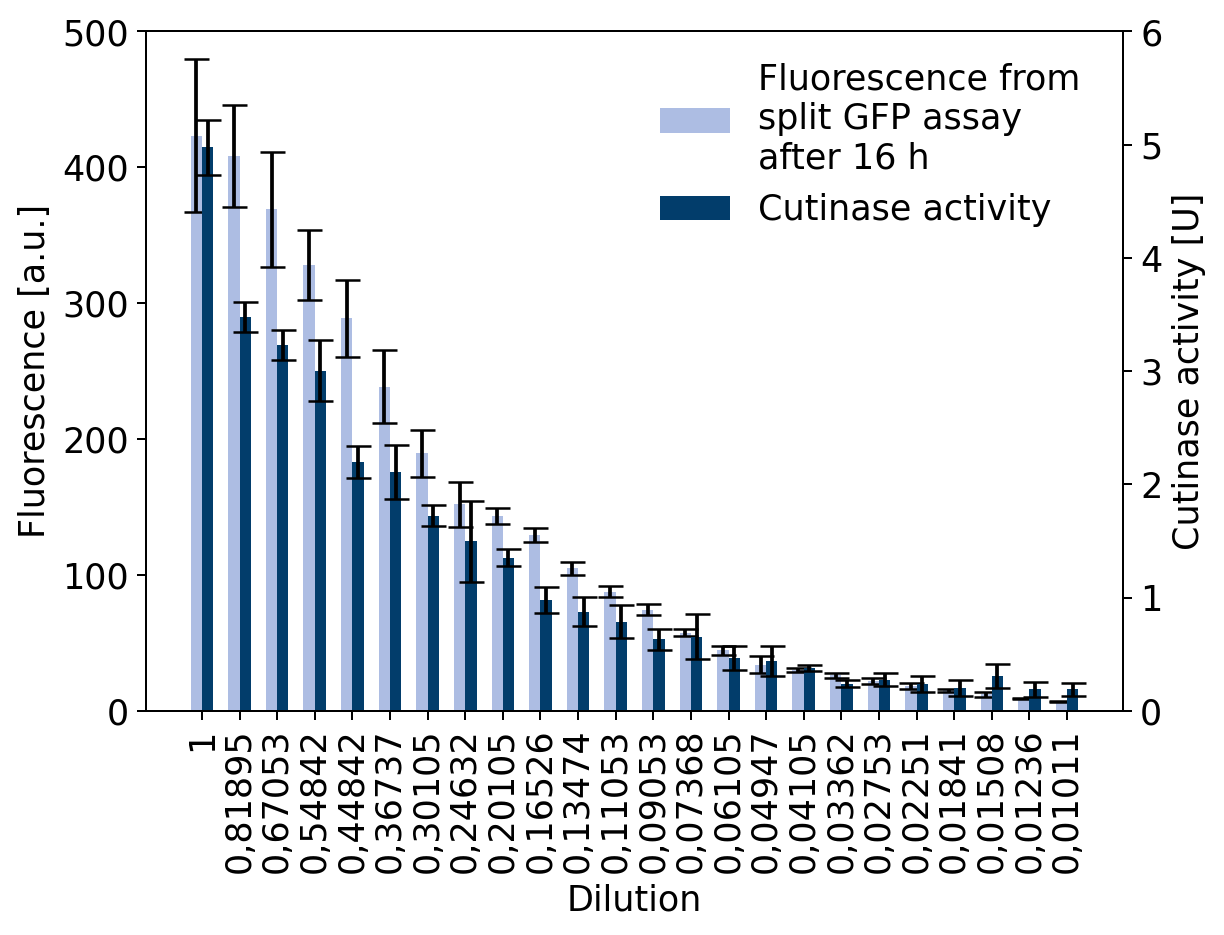

In [50]:
x = numpy.arange(len(strain))
w = 0.3
fontsize = 14
comparison = plt.figure(figsize=(7, 5), dpi=180)
ax1 = plt.subplot(1,1,1)

#plt.xticks(), will label the bars on x axis with the respective strain names.
plt.xticks(x + w /2, sGFP['Dilution'], rotation=90, fontsize = fontsize)
Fluorescence = ax1.bar(x, sGFP['Fluorescence [a.u.]'], yerr = sGFP['Standard deviation'], capsize =5, width=w, color='#ADBDE3', align='center')
plt.ylabel('Fluorescence [a.u.]', fontsize = fontsize)
plt.xlabel('Dilution', fontsize=fontsize)#('Signal peptide', fontsize = 14)
plt.yticks(fontsize = fontsize)
ax1.set_ylim(0,500)

#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()
Activity =ax2.bar(x + w, ca['Cutinase activity [U]'], yerr = ca['Standard deviation'], capsize =5, width=w,color='#023D6B',align='center')
plt.ylabel('Cutinase activity [U]', fontsize = fontsize)
plt.yticks(fontsize = fontsize)
ax2.set_ylim(0,6)

plt.legend([Fluorescence, Activity],['Fluorescence from \nsplit GFP assay \nafter 16 h', 'Cutinase activity'], loc = 'upper right', frameon = False, fontsize = fontsize)


In [51]:
comparison.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_Comparison_sGFP-cutinase', dpi=600)#, bbox_inches='tight')

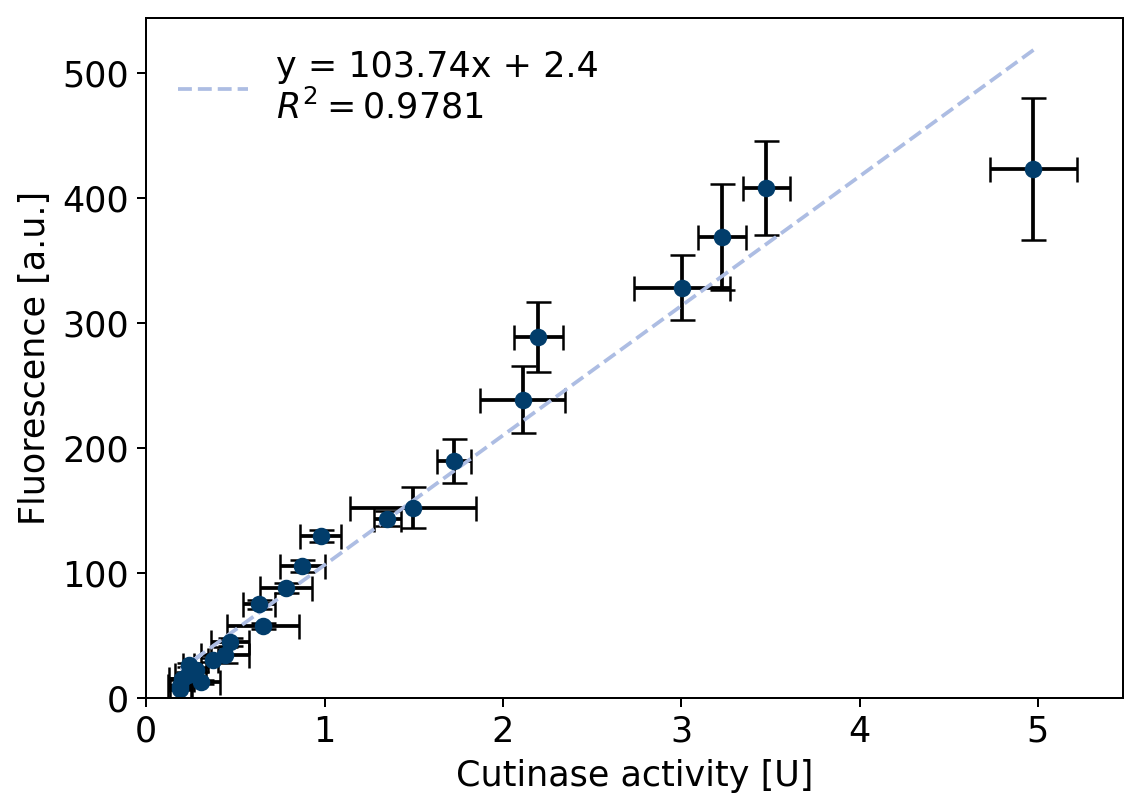

In [52]:
fontsize = 14

calib_slope, calib_intercept, calib_r_value, calib_p_value, calib_std_err = scipy.stats.linregress(
    ca['Cutinase activity [U]'], sGFP['Fluorescence [a.u.]'])
calib_r_value = round(calib_r_value,4)
calib_slope = round(calib_slope, 4)
calib_intercept = round(calib_intercept, 4)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,5), dpi = 180)

ax.errorbar(ca['Cutinase activity [U]'], sGFP['Fluorescence [a.u.]'],color = '#023D6B', yerr = sGFP['Standard deviation'], xerr = ca['Standard deviation'], capsize = 5,
            fmt = 'o', ecolor= 'k')
ax.plot(ca['Cutinase activity [U]'], calib_intercept + calib_slope*ca['Cutinase activity [U]'], 'r', 
        label=f'y = {round(calib_slope,2)}x + {round(calib_intercept,2)} \n$R^2 = {calib_r_value}$', color = '#ADBDE3', ls ='--')

ax.legend(frameon = False, fontsize = fontsize)

ax.set_ylim(0,)
ax.set_xlim(0,)

ax.set_xlabel('Cutinase activity [U]', fontsize = fontsize) #, fontweight = 'bold')
ax.set_ylabel('Fluorescence [a.u.]', fontsize = fontsize) #, fontweight = 'bold')

ax.tick_params(labelsize=fontsize)

# fig.tight_layout()

fig.savefig(fr'{dir_experiment}\{experiment_name}_Results\{experiment_name}_Correlation_sGFP-cutinase', dpi=600, bbox_inches='tight')